# Reproducibility with original data

This tutorial demonstrates how to identify spatial domains on 10x Visium human dorsolateral prefrontal cortex data using Pysodb and STAGATE based on pyG (PyTorch Geometric) framework.

A reference paper can be found at https://www.nature.com/articles/s41467-022-29439-6.

This tutorial refers to the following tutorial at https://stagate.readthedocs.io/en/latest/T1_DLPFC.html. At the same time, the way of loadding data is modified by using Pysodb.

## Import packages and set configurations

In [1]:
# Use Python warnings module to filter and ignore any warnings that may occur in the program after this point.
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import several Python packages commonly used in data analysis and visualization:
# pandas (imported as pd) is a package for data manipulation and analysis
import pandas as pd
# numpy (imported as np) is a package for numerical computing with arrays
import numpy as np
# scanpy (imported as sc) is a package for single-cell RNA sequencing analysis
import scanpy as sc
# matplotlib.pyplot (imported as plt) is a package for data visualization
import matplotlib.pyplot as plt
# os is a package for interacting with the operating system, such as reading or writing files
import os

In [3]:
# Import the adjusted_rand_score function from the sklearn.metrics.cluster module of the scikit-learn library. 
from sklearn.metrics.cluster import adjusted_rand_score

In [4]:
# Import STAGATE_pyG package
import STAGATE_pyG

If users encounter the error "No module named 'STAGATE_pyG'" when trying to import STAGATE_pyG package, first ensure that the "STAGATE_pyG" folder is located in the current script's directory.

In [5]:
# The location of R (used for the mclust clustering)
os.environ['R_HOME'] = '/home/<usr_name>/anaconda3/envs/<environment_name>/lib/R/'
os.environ['R_USER'] = '/home/<usr_name>/anaconda3/envs/<environment_name>/lib/R/rpy2'

When configuring the installation paths for R_HOME and R_LIBS_USER, the standard Linux and Conda environment paths (such as .conda) may not be applicable. In such cases, users need to locate the R path and library path within the Conda virtual environment's Python packages and replace them accordingly.If the commands has been configured during the installation, users do not need to run the preceding commands.

## Streamline development of loading spatial data with Pysodb

In [6]:
# Import pysodb package
# Pysodb is a Python package that provides a set of tools for working with SODB databases. 
# SODB is a format used to store data in memory-mapped files for efficient access and querying. 
# This package allows users to interact with SODB files using Python.
import pysodb

In [7]:
# Initialization
sodb = pysodb.SODB()

In [8]:
# Define names of the dataset_name and experiment_name
dataset_name = 'maynard2021trans'
experiment_name = '151676'
# Load a specific experiment
# It takes two arguments: the name of the dataset and the name of the experiment to load.
# Two arguments are available at https://gene.ai.tencent.com/SpatialOmics/.
adata = sodb.load_experiment(dataset_name,experiment_name)

load experiment[151676] in dataset[maynard2021trans]


In [9]:
adata

AnnData object with n_obs × n_vars = 3460 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Region', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

## Data preprocessing

In [10]:
# Ensure that the variable names (i.e., the column names in the .var DataFrame) are unique
adata.var_names_make_unique()

In [11]:
# Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)  
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

When encountering the Error "Please install skmisc package via 'pip install --user scikit-misc'", users can follow the provided instructions: activate the virtual environment at the terminal, execute "pip install --user scikit-misc", and then restart the kernel to ensure the package is properly installed and available for use.

## Constructing the spatial network

------Calculating spatial graph...
The graph contains 20052 edges, 3460 cells.
5.7954 neighbors per cell on average.


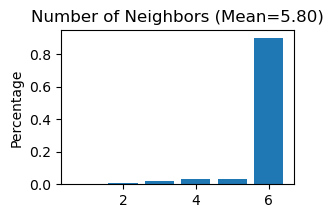

In [12]:
# Use "STAGATE_pyG.Cal_Spatial_Net" to calculate a spatial graph with a radius cutoff of 150.
STAGATE_pyG.Cal_Spatial_Net(adata, rad_cutoff=150)
# Use "STAGATE_pyG.Stats_Spatial_Net" to summarize cells and edges information.
STAGATE_pyG.Stats_Spatial_Net(adata)

## Running STAGATE

In [13]:
# Train a STAGATE model 
adata = STAGATE_pyG.train_STAGATE(adata)

Size of Input:  (3460, 3000)


100%|██████████| 1000/1000 [00:06<00:00, 145.57it/s]


## Spatial Clustering

In [14]:
# Calculate the nearest neighbors in the 'STAGATE' representation and computes the UMAP embedding.
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)

In [15]:
# Use Mclust_R to cluster cells in the 'STAGATE' representation into 7 clusters.
adata = STAGATE_pyG.mclust_R(adata, used_obsm='STAGATE', num_cluster=7)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [16]:
# Compute the adjusted rand index (ARI) between the 'mclust' and the 'Ground Truth'. 
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Region'])
print('Adjusted rand index = %.2f' %ARI)

Adjusted rand index = 0.62


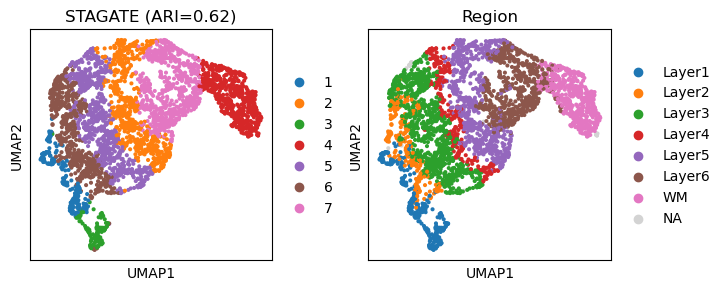

In [17]:
# Generate a plot of the UMAP embedding colored by both a mclust and a ground truth.
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color=["mclust", "Region"], title=['STAGATE (ARI=%.2f)'%ARI, "Region"])

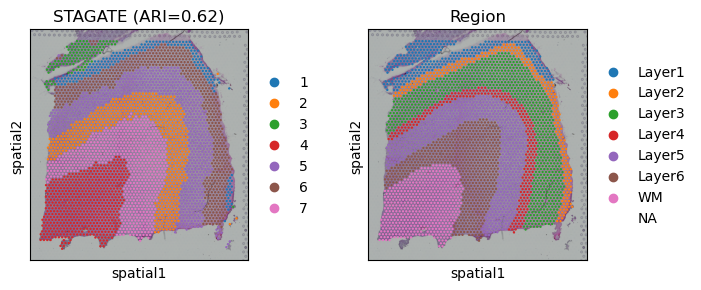

In [18]:
# Visualize the result using mclust and Ground Truth.
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, color=["mclust", "Region"], title=['STAGATE (ARI=%.2f)'%ARI, "Region"])

## Spatial trajectory inference (PAGA)

In [19]:
"""
used_adata = adata[adata.obs['Ground Truth']!='nan']
used_adata
"""

"\nused_adata = adata[adata.obs['Ground Truth']!='nan']\nused_adata\n"

In [20]:
# Exclude any cells with missing values in the 'Ground Truth' column of the observation metadata.
used_adata = adata[pd.notna(adata.obs['Region'])]
used_adata

View of AnnData object with n_obs × n_vars = 3431 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Region', 'leiden', 'mclust'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_rank', 'variances', 'variances_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial', 'spatial_neighbors', 'umap', 'Spatial_Net', 'mclust_colors', 'Region_colors'
    obsm: 'X_pca', 'X_umap', 'spatial', 'STAGATE'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [21]:
# Use PAGA to infer differentiation trajectories.
sc.tl.paga(used_adata, groups='Region')

[<Axes: xlabel='UMAP1', ylabel='UMAP2'>, <Axes: >]

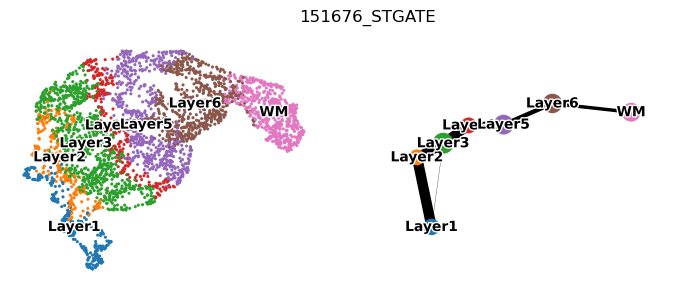

In [22]:
# Compare partition-based graph abstraction (PAGA) results.
plt.rcParams["figure.figsize"] = (4,3)
sc.pl.paga_compare(used_adata, legend_fontsize=10, frameon=False, size=20,
                   title=experiment_name+'_STGATE', legend_fontoutline=2, show=False)